# Compare Data
This script is used to compare some of the simulations and different agent configurations

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# import general stuff
import gym
import random
import torch
import numpy as np
from collections import deque
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
# widget bar to display progress
!pip install progressbar
import progressbar as pb

# import specific / own stuff
from ddpg_agent import Agent

import torch.nn as nn

### plot the main results plot

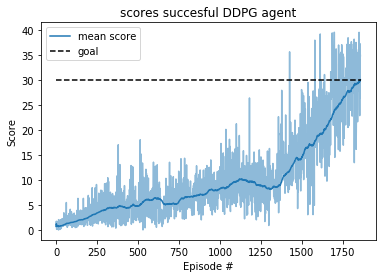

In [2]:
with open('./data/scores_DDPG_tmax2000_episodes2500_epsEnd2500.pkl', 'rb') as f:
    scores = pickle.load(f)
    
def moving_average(sig, n=100):
    window = deque(maxlen=n)  # last n scores
    sig_ma = []
    for i in range(len(sig)):
        window.append(sig[i])
        sig_ma.append(np.mean(window))
    return sig_ma

scores_ma = moving_average(scores)
h = plt.plot(scores, alpha=0.5)
plt.plot(scores_ma, label='mean score', c=h[-1].get_color())
plt.plot([0, len(scores)], [30, 30], 'k--', label='goal')
plt.legend(loc='best')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('scores succesful DDPG agent')
plt.savefig('./data/DDPG_results_report.png')
plt.show()

### load data for comparing multiple runs with the same parameterization

In [3]:
with open('./data/scores_DDPG_tmax2000_episodes2000_twoHiddenlayer_1.pkl', 'rb') as f:
    scores_1 = pickle.load(f)
with open('./data/scores_DDPG_tmax2000_episodes2000_twoHiddenlayer_2.pkl', 'rb') as f:
    scores_2 = pickle.load(f)
with open('./data/scores_DDPG_tmax2000_episodes2000_twoHiddenlayer_3.pkl', 'rb') as f:
    scores_3 = pickle.load(f)

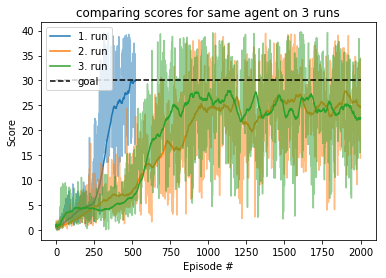

In [4]:
# butterworth filter with [order] and [cutofffreq/nyquistfreq]
b, a = signal.butter(4, 0.05/0.5)


def moving_average(sig, n=100):
    window = deque(maxlen=n)  # last n scores
    sig_ma = []
    for i in range(len(sig)):
        window.append(sig[i])
        sig_ma.append(np.mean(window))
    return sig_ma

scores_1_ma = moving_average(scores_1)
scores_2_ma = moving_average(scores_2)
scores_3_ma = moving_average(scores_3)
h = plt.plot(scores_1, alpha=0.5)
plt.plot(scores_1_ma, label='1. run', c=h[-1].get_color())
h = plt.plot(scores_2, alpha=0.5)
plt.plot(scores_2_ma, label='2. run', c=h[-1].get_color())
h = plt.plot(scores_3, alpha=0.5)
plt.plot(scores_3_ma, label='3. run', c=h[-1].get_color())
plt.plot([0, 2000], [30, 30], 'k--', label='goal')
plt.legend(loc='best')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('comparing scores for same agent on 3 runs')
plt.savefig('./data/DDPG_compare_runs.png')
plt.show()

 # Simulate Ornstein-Uhlenbeck process
 This process is used for exploration. In the next short section it is simulated with different parameterization to get a better feeling what it is doing.

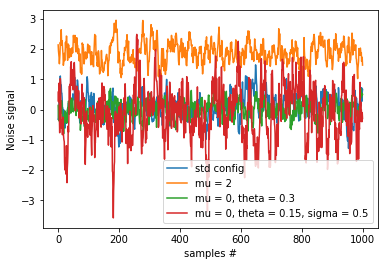

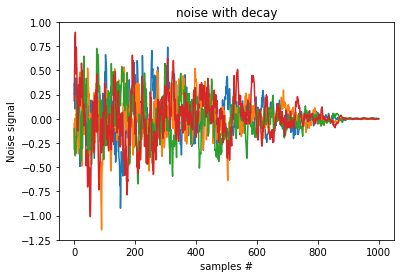

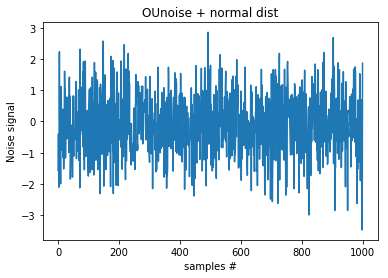

tensor([[1.]], grad_fn=<ExpBackward>)
tensor([[1.4189]], grad_fn=<AddBackward>)


In [19]:
from ddpg_agent import OUNoise
import random
random_seed = 123

# Noise process
# mu=0., theta=0.15, sigma=0.2
# mu is the center point of the distribution
# theta draws the distribution towards the center point
# sigma draws the distribution towards random points of normal distribution
noise_std = OUNoise(1, random_seed)
noise_1 = OUNoise(1, random_seed, 2)
noise_2 = OUNoise(1, random_seed, 0., 0.3)
noise_3 = OUNoise(1, random_seed, 0., 0.15, 0.5)

# create noise
n_samples = 1000
noise_signal_std = [noise_std.sample() for i in range(n_samples)]
noise_signal_1 = [noise_1.sample() for i in range(n_samples)]
noise_signal_2 = [noise_2.sample() for i in range(n_samples)]
noise_signal_3 = [noise_3.sample() for i in range(n_samples)]

plt.plot(noise_signal_std, label='std config')
plt.plot(noise_signal_1, label='mu = 2')
plt.plot(noise_signal_2, label='mu = 0, theta = 0.3')
plt.plot(noise_signal_3, label='mu = 0, theta = 0.15, sigma = 0.5')
plt.legend(loc='best')
plt.ylabel('Noise signal')
plt.xlabel('samples #')
plt.show()

# with beta decay
noise_std = OUNoise(4, random_seed)
beta_start=1.0
beta_end=0.01
beta_nEpisodes=900
beta = beta_start                  # initialize beta, that is factor for adding noise
beta_decay_linear = (beta_start-beta_end)/beta_nEpisodes # compute linear beta decay rate
noise_signal_beta = [noise_std.sample() for i in range(n_samples)]
for i in range(n_samples):
    noise_signal_beta[i] *= beta
    beta = max(beta_end, beta_start - beta_decay_linear*i) # decrease beta
plt.plot(noise_signal_beta)
plt.ylabel('Noise signal')
plt.xlabel('samples #')
plt.title('noise with decay')
plt.show()

# with additional normal distribution
noise_std = OUNoise(1, random_seed)
log_std = nn.Parameter(torch.ones(1, 1) * 0.0)
std = log_std.exp()
dist  = torch.distributions.Normal(0.0, std) # (mu,std)
noise_signal = [noise_std.sample()+dist.sample() for i in range(n_samples)]
noise_signal = [dist.sample() for i in range(n_samples)]
plt.plot(noise_signal)
plt.ylabel('Noise signal')
plt.xlabel('samples #')
plt.title('OUnoise + normal dist')
plt.show()
print(std)
print(dist.entropy())

showing some entropy results from torch.distributions.Normal

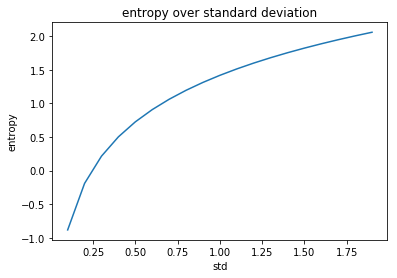

In [40]:
stds = np.arange(0.0, 2.0, 0.1)
entrps = np.zeros(stds.size)
for i in range(stds.size):
    dist  = torch.distributions.Normal(0.0, stds[i]) # (mu,std)
    entrps[i] = dist.entropy()

plt.plot(stds, entrps)
plt.title('entropy over standard deviation')
plt.xlabel('std')
plt.ylabel('entropy')
plt.show()

# PLAYGROUND - PROBABLY NOT WORTH INVESTIGATING

In [6]:
env = UnityEnvironment(file_name='.\Reacher_Windows_x86_64\Reacher.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# random actions
actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
print('Random set of actions: {}'.format(actions))

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
Random set of actions: [[-0.51449843  0.65599879 -1.         -1.        ]]
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Check if distribution of PPO Agent works and gives expected results

In [7]:
import torch.nn as nn
from models import ActorPolicy

state_size = 33
action_size = 4
seed= 123
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_layers = [33, 33]
munetwork_local = ActorPolicy(state_size, action_size, hidden_layers, seed).to(device)

std = 0.0
log_std = nn.Parameter(torch.ones(1, action_size) * std)
print(log_std)

mu = munetwork_local(torch.from_numpy(states).float().to(device))
std   = log_std.exp().expand_as(mu).to(device)
dist  = torch.distributions.Normal(mu, std)

print(mu, std)
print(dist.sample())

Parameter containing:
tensor([[0., 0., 0., 0.]], requires_grad=True)
tensor([[-0.2714,  0.2198,  0.3821, -0.0295]],
       device='cuda:0', grad_fn=<TanhBackward>) tensor([[1., 1., 1., 1.]], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([[-1.9418, -0.6393, -0.3784,  0.1150]], device='cuda:0')


In [8]:
from models import ActorPPO

print([states, states])
actor_network = ActorPPO(state_size, action_size, hidden_layers, seed).to(device)
mu, dist = actor_network(torch.from_numpy(states).float().to(device))

samples = torch.Tensor().to(device)
for i in range(1000):
    samples = torch.cat((samples, dist.sample()), dim=0)
    
#print(samples)
print('Compute mean value of 1000 samples:')
print(torch.mean(samples,dim=0))
print('Original mean value of distribution ist:')
print(mu)
print('')
print('Standard Deviation should be close to one:')
print(torch.std(samples,dim=0))

[array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -4.37113883e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.75471878e+00,
        -1.00000000e+00,  5.55726671e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -1.68164849e-01]]), array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e+00, -0.0000000

In [9]:
actions = torch.tensor(actions, dtype=torch.float32, device=device)
print(actions)
print(dist)
print(dist.log_prob(actions))
print(samples.size())
print(dist.sample()[0])

tensor([[-0.5145,  0.6560, -1.0000, -1.0000]], device='cuda:0')
Normal()
tensor([[-0.9485, -1.0141, -1.8740, -1.3899]],
       device='cuda:0', grad_fn=<SubBackward>)
torch.Size([1000, 4])
tensor([0.1761, 0.9405, 0.7987, 0.6332], device='cuda:0')


In [10]:
def sample(states):
    idx = np.random.randint(0, states.size(0),2)
    return states[idx,:]

print(sample(samples))

score = 2
trajectory = []
trajectory.append([score, actions, states])
trajectory.append([score, actions, states])
print(trajectory)
a,b,c = trajectory[0]
print(a,b,c)


tensor([[ 0.6959,  0.4899,  1.9986,  0.2367],
        [ 0.2374,  1.0442, -0.4757,  0.4943]], device='cuda:0')
[[2, tensor([[-0.5145,  0.6560, -1.0000, -1.0000]], device='cuda:0'), array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -4.37113883e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.75471878e+00,
        -1.00000000e+00,  5.55726671e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -1.68164849e-01]])], [2, tensor([[-0.5145,  0.6560, -1.0000, -1.0000]], device='cuda:0'), array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+0

In [11]:
print(np.arange(len([1, 2, 3])))

[0 1 2]


## get one sample trajectory

# SOME TESTING

In [13]:
import random
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
GAMME = 0.99

states = torch.empty(200,33, dtype=torch.float, device=device)
actions = torch.empty(200,4, dtype=torch.float, device=device)
rewards = torch.empty(200,1, dtype=torch.float, device=device)

# check sizes
print('Size states {}'.format(states.size()))
print('Size actions {}'.format(actions.size()))
print('Size rewards {}'.format(rewards.size()))

# convert rewards to future rewards
rewards_future = torch.empty(rewards.shape[0], rewards.shape[1], dtype=torch.float, device=device)
for i in range(rewards.shape[0]):
    rewards_future[i,:] = torch.sum(rewards[i:,:],dim=0)
print('Size future rewards {}'.format(rewards_future.size()))    

Size states torch.Size([200, 33])
Size actions torch.Size([200, 4])
Size rewards torch.Size([200, 1])
Size future rewards torch.Size([200, 1])


In [15]:
values = torch.ones(4, 1, dtype=torch.float, device=device)
values[0] = 1
values[1] = 2
values[2] = 2
values[3] = 3
print(values)
next_values = torch.zeros(values.size(0),1, dtype=torch.float, device=device)
next_values[:-1] = values[1:]
print(next_values)

tensor([[1.],
        [2.],
        [2.],
        [3.]], device='cuda:0')
tensor([[2.],
        [2.],
        [3.],
        [0.]], device='cuda:0')


In [16]:
GAMMA = 0.99            # discount factor
LAMBDA = 0.95           # Value for Generalized Advantage Estimation, lambda = 0 --> 1 step TD estimate

rewards = torch.ones(4, 1, dtype=torch.float, device=device)
rewards[0] = 1
rewards[1] = 2
rewards[2] = 2
rewards[3] = 3

td_error = rewards + GAMMA*next_values - values

discount = (GAMMA*LAMBDA)**torch.arange(len(rewards), dtype=torch.float, device=device)
print(discount)
print(td_error)
print(td_error.size())

print(td_error[0:,:])
print(discount[0:-0])
# compute advantage function
advantages = torch.empty(rewards.shape[0], rewards.shape[1], dtype=torch.float, device=device)
for i in range(advantages.shape[0]):
    if i == 0:
        advantages[i,:] = torch.sum(td_error[i:,:]*torch.unsqueeze(discount[:],1),dim=0)
    else:
        advantages[i,:] = torch.sum(td_error[i:,:]*torch.unsqueeze(discount[0:-i],1),dim=0)
print(advantages)

tensor([1.0000, 0.9405, 0.8845, 0.8319], device='cuda:0')
tensor([[1.9800],
        [1.9800],
        [2.9700],
        [0.0000]], device='cuda:0')
torch.Size([4, 1])
tensor([[1.9800],
        [1.9800],
        [2.9700],
        [0.0000]], device='cuda:0')
tensor([], device='cuda:0')
tensor([[6.4693],
        [4.7733],
        [2.9700],
        [0.0000]], device='cuda:0')


In [17]:
print(0.98 + 0.9405*1.9800 + 0.8845*2.9700 + 0.8319*0.0000)
print(1.9800 + 0.9405*2.9700 + 0.8845*0.0000)
print(2.9700 + 0.9405*0.0000)
print(0.0000)

5.469155000000001
4.773285
2.97
0.0


In [18]:
BATCH_SIZE = 64
GD_EPOCH = 20

i = 0
for _ in range(1001 // BATCH_SIZE):
    i +=1
    print('{}'.format(i))

print('number of runs: {}'.format(i*GD_EPOCH))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
number of runs: 300
